# Advanced functionality


In [11]:
from reflectorch import get_trainer_by_name

import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

## Model with absorption (imaginary part of the SLD)

Our default models presented so far take into account only the real part of the SLD profile but neglect the imaginary part of the SLD which is related to the absorption of the scattering medium. While this is a reasonable approximation in many use cases, in reflectorch we are also able to train an employ models in which the SLD profile is parameterized as to incorporate the imaginary SLD of the layers.

We can initialize a reflectorch model with absorption by making the following changes to the YAML configuration file:

 1. The definition of the *prior sampler* must be changed so that the parameter range and bound width range for the imaginary layer SLDs (*islds*) are also specified. In addition, the *model_name* key must be set to 'model_with_absorption' instead of 'standard_model'.

```yaml
dset:
  prior_sampler:
    cls: SubpriorParametricSampler
    kwargs:
      param_ranges:
        thicknesses: [0., 300.]
        roughnesses: [0., 40.]
        slds: [0., 60.]
        islds: [0., 10.]
      bound_width_ranges:
        thicknesses: [ 1.0e-2, 300. ]
        roughnesses: [ 1.0e-2, 40. ]
        slds: [ 1.0e-2, 4. ]
        islds: [ 1.0e-2, 5. ]
      model_name: model_with_absorption
      max_num_layers: 2
      constrained_roughness: true
      max_thickness_share: 0.5
      logdist: false
```

2. For the 2-layer box model parameterization of the SLD profile without absorption, the neural network had to predict 8 values (2 thicknesses, 3 roughnesses, 3 real layer SLDs). When absorption is considered, we have 3 additional output values (the imaginary layer SLDs), summing up to a total of 11. The number of input prior bound values also increases to 2*11 = 22 (the computation for a higher number of layers is analogous). Thus the neural network architecture must also reflect theses changes in the input and output dimensionalities: the *latent_dim* key (i.e. the output dimension) is set to 11 and the *prior_in_features* key is set to 22.

```yaml
model:
  encoder:
    cls: PriorInformedNetworkConvEmb
    pretrained_name: null
    kwargs:
       hidden_dims: [32, 64, 128, 256, 512]
       latent_dim: 11
       conv_latent_dim: 128
       avpool: 1
       use_batch_norm: true
       in_features: 256
       prior_in_features: 22
       hidden_features: 1024
       num_blocks: 6  #3
       fc_activation: 'gelu'
       conv_activation: 'gelu'
       pass_bounds: false
       pretrained_conv: null
```

We initialize a model with absorption from a suitable configuration file.

In [12]:
trainer = get_trainer_by_name(model_name='l2q256_absorption_1.yaml', load_weights=False)

Model l2q256_absorption_1.yaml loaded. Number of parameters: 2.77 M


In [16]:
simulated_data = trainer.loader.get_batch(batch_size=64)

n_layers = simulated_data['params'].max_layer_num
n_params = simulated_data['params'].num_params

print(f'Number of layers: {n_layers},  Number of film parameters: {n_params}')

Number of layers: 2,  Number of film parameters: 11


As expected, we observe that the absorption leads to a change in the shape of the total reflection edge.

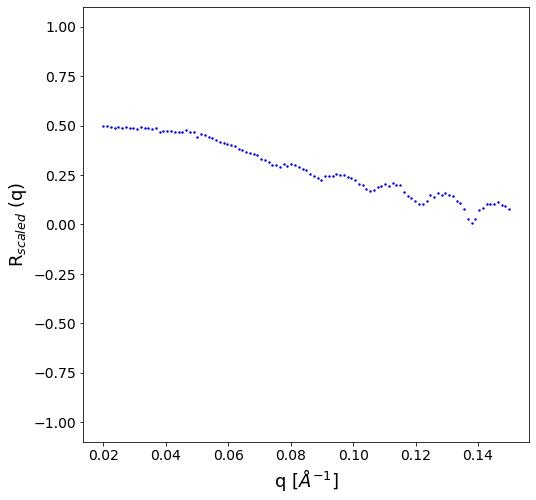

In [15]:
q = simulated_data['q_values'][0].cpu().numpy()
scaled_noisy_curves = simulated_data['scaled_noisy_curves']

i = 30

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=18)
ax.set_ylabel('R$_{scaled}$ (q)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
    
ax.scatter(q, scaled_noisy_curves[i].cpu().numpy(), c='blue', s=2.0)

In [20]:
!python --version

Python 3.7.6


## Alternative parameterizations of the SLD profile

In this section we describe alternative parameterizations of the SLD profile implementated into reflectorch (i.e. other than the standard box model parameterization)

### Periodically repeating multilayer

This SLD parameterization addresses the following commonly encountered scenario for thin films. On top of a silicon/silicon oxide substrate we consider a thin film composed of repeating identical monolayers (grey curve in the figure), each monolayer consisting of two boxes with distinct SLDs. A sigmoid envelope modulating
the SLD profile of the monolayers defines the film thickness and the roughness at the top
interface (green curve in the figure). A second sigmoid envelope can be used to modulate
the amplitude of the monolayer SLDs as a function of the displacement from the position
of the first sigmoid (red curve in the figure). These two sigmoids allow one to model a
thin film that is coherently ordered up to a certain coherent thickness and gets incoherently
ordered or amorphous toward the top of the film. In addition, a layer between the
substrate and the multilayer (i.e. ”phase layer”) is introduced to account for the interface structure, which does not necessarily have to be identical to the multilayer period.

```{figure} sketch_multilayer_0.png
:scale: 50
:align: center
:name: figure_multilayer
SLD parameterization of a periodically repeating multilayer
```

This parameterization has a total of 17 film parameters, their physical description together with their corresponding alias in the YAML configuration file being shown in the following table:

| **Parameter description** | **Parameter alias in the configuration file** |
|---------------|---------------------|
| monolayer thickness (i.e. two boxes stacked together) | d_block |
| relative roughness of the monolayer interfaces (wrt. the monolayer thickness) | s_block_rel |
| SLD of the first box in the monolayer | r_block |
| SLD difference between the second and the first box in the monolayer | dr |
| fraction of the monolayer thickness belonging to the first box | d_block1_rel |
| roughness of the silicon substrate | s_si |
| SLD of the silicon substrate | r_si |
| thickness of the silicon oxide layer | d_sio2 |
| roughness of the silicon oxide layer | s_sio2 |
| SLD of the silicon oxide layer | r_sio2 |
| SLD of the phase layer | r3 |
| relative thickness of the phase layer (wrt. the monolayer thickness) | d3_rel |
| relative roughness of the phase layer (wrt. the monolayer thickness) | s3_rel |
| relative position of the first sigmoid (i.e. total film thickness) | d_full_rel |
| relative width of the first sigmoid | rel_sigmas |
| relative position of the second sigmoid (coherently ordered film thickness) | dr_sigmoid_rel_pos |
| relative width of the second sigmoid | dr_sigmoid_rel_width |

We can initialize a reflectorch model which uses this SLD parameterization by making the following changes to the YAML configuration file:

 1. The definition of the *prior sampler* must be changed so that the parameter range and bound width range for the 17 multilayer parameters are specified (the above table shows the correspondance between the phhysical parameters and the corresponding YAML keys). In addition, the *model_name* key must be set to 'model3' instead of 'standard_model', and the 'max_num_layers' key is set to high value (e.g. 30).

```yaml
dset:
  prior_sampler:
    cls: SubpriorParametricSampler
    kwargs:
      param_ranges:
          d_full_rel: [0, 25]
          rel_sigmas: [0, 5]
          dr_sigmoid_rel_pos: [-10, 10]
          dr_sigmoid_rel_width: [0, 20]
          d_block1_rel: [0.01, 0.99]
          d_block: [10, 20]
          s_block_rel: [0., 0.3]
          r_block: [0., 20.] 
          dr: [-10., 10.]
          d3_rel: [0, 1] 
          s3_rel: [0, 1] 
          r3: [0., 25] 
          d_sio2: [0, 10] 
          s_sio2: [0, 10] 
          s_si: [0., 10] 
          r_sio2: [17., 19.]
          r_si: [19., 21.]
      bound_width_ranges:
          d_full_rel: [0.1, 25]
          rel_sigmas: [0.1, 5]
          dr_sigmoid_rel_pos: [0.1, 20]
          dr_sigmoid_rel_width: [0.1, 20]
          d_block1_rel: [0.01, 1.0]
          d_block: [0.1, 10.]
          s_block_rel: [0.1, 0.3]
          r_block: [0.1, 5.]
          dr: [0.1, 5.]
          d3_rel: [0.01, 1]
          s3_rel: [0.01, 1]
          r3: [0.01, 25]
          d_sio2: [0.01, 10]
          s_sio2: [0.01, 10]
          s_si: [0.01, 10]
          r_sio2: [0.01, 2]
          r_si: [0.01, 2]
      model_name: model3
      max_num_layers: 30
      logdist: false
```

2. The neural network architecture must be set up such that the *latent_dim* key (i.e. the output dimension) is set to the number of predicted parameters (17) and the *prior_in_features* key is set to double that number (34).

```yaml
model:
  encoder:
    cls: PriorInformedNetworkConvEmb
    pretrained_name: null
    kwargs:
       hidden_dims: [32, 64, 128, 256, 512]
       latent_dim: 17
       conv_latent_dim: 128
       avpool: 8
       use_batch_norm: true
       in_features: 256
       prior_in_features: 34
       hidden_features: 1024
       num_blocks: 6
       fc_activation: 'gelu'
       conv_activation: 'gelu'
       pass_bounds: false
       pretrained_conv: null
```

## Using different embedding networks

Embedding networks have the role of processing the reflectivity curves, producing a latent representation which is fed together with the prior bounds to the main fully-connected (MLP) network.

......

```{figure} fig_reflectometry_embedding_networks.png
:scale: 25 %
:align: center
:name: embedding_networks
Embedding Networks
```

## Just some temorary elements

```python
from a import b
c = "string"
```

```{code-block} python
:caption: This is a caption
:emphasize-lines: 2,3
:lineno-start: 1

a = 1
b = 2
c = 3
```

```{margin} An optional title
My margin content
```

```{dropdown} Here's my dropdown
Dropdown content
```

````{tab-set}
```{tab-item} Tab 1 title
My first tab
```

```{tab-item} Tab 2 title
My second tab with `some code`!
```
````

$$
  \int_0^\infty \frac{x^3}{e^x-1}\,dx = \frac{\pi^4}{15}
$$

In [120]:
!python --version

Python 3.7.6
